### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test
import pandas as pd
import random

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\mBRSET\\mbrset-a-mobile-brazilian-retinal-dataset-1.0\\'
HOME_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\' # change this as appropriate 
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv') #labels.csv when partitioning by image

#---------------------------------

IMAGE_COL = 'file'
NORM_MEAN =  [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
BACKBONE = 'resnet50'
#BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 64 #16
NUM_WORKERS = 8 #4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'
USE_RELU = True #addition of RELU for final model classification, between the two linear layers after the backbone
# Define your hyperparameters
num_epochs = 50 
learning_rate = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [4]:
df = pd.read_csv(LABELS_PATH)
print(df.shape)

#Check for nans
nan_counts = df.isna().sum()
print(df.shape)
print(nan_counts)
# Fill missing labels as normal
df[LABEL] = df[LABEL].fillna(0)
df.head(5)

(5164, 24)
(5164, 24)
patient                           0
age                               0
sex                               0
dm_time                          56
insulin                          48
insulin_time                   4148
oraltreatment_dm                 44
systemic_hypertension            44
insurance                        48
educational_level                52
alcohol_consumption              76
smoking                          88
obesity                          76
vascular_disease                 76
acute_myocardial_infarction      84
nephropathy                      80
neuropathy                       76
diabetic_foot                   108
file                              0
laterality                        0
final_artifacts                   0
final_quality                     0
final_icdr                      280
final_edema                     265
dtype: int64


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,acute_myocardial_infarction,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no


Train data shape: (3614, 24)
Test data shape: (1550, 24)


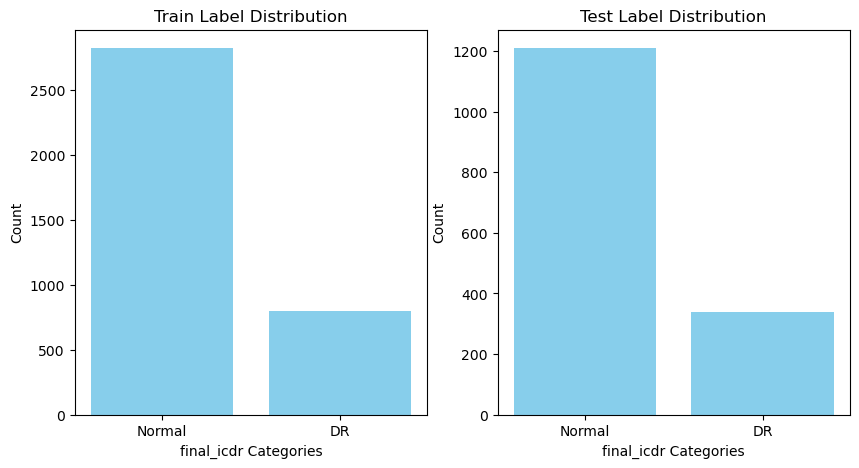

Getting validation set...
Train data shape: (1240, 24)
Test data shape: (310, 24)


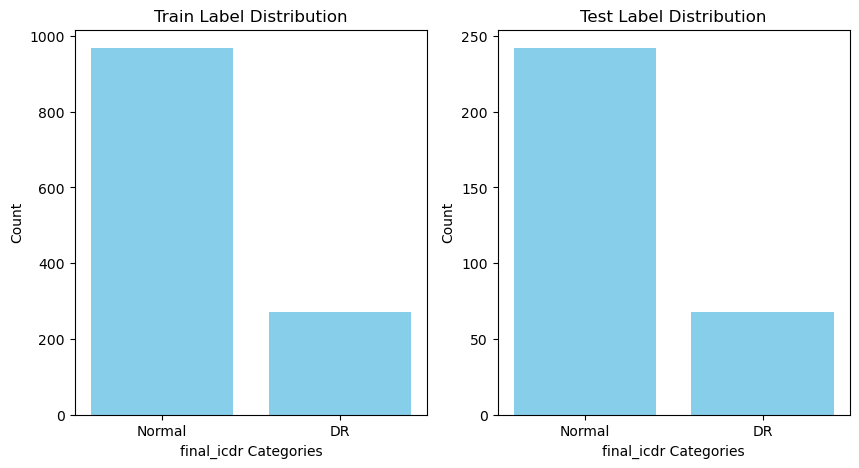

In [5]:
# Split dataset into train, test and validation:
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0.0 else ('DR'))
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)


357     {Normal}
3654    {Normal}
4965    {Normal}
465     {Normal}
558         {DR}
          ...   
3315    {Normal}
2181    {Normal}
4263    {Normal}
4641    {Normal}
1651        {DR}
Name: final_icdr, Length: 3614, dtype: object


In [7]:

# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

#Here we have added additional transforms: color jitter and random vertical flip to the training image embeddings
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.0, hue=0.0),

])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom datasets
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

#Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

DF col dtype object final_icdr
DF col dtype object final_icdr
DF col dtype object final_icdr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


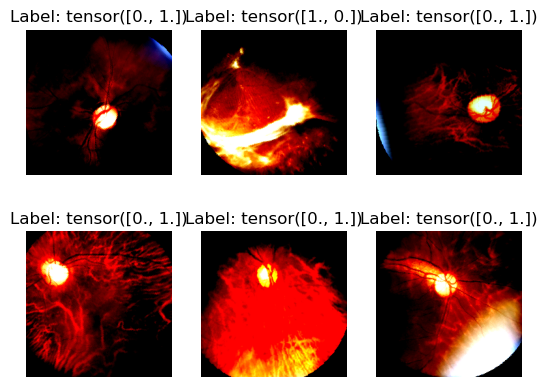

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels after transforms
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']
    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, relu= USE_RELU, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)
    print(class_indices)
    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

[1 1 1 ... 1 1 0]


In [12]:
save_dir= HOME_DIR + 'Experiment2'
model = train(model, train_dataloader, val_dataloader,test_dataloader, criterion, optimizer, scheduler=None,num_epochs=num_epochs, save=True, save_dir = save_dir,device="cuda", backbone=f'convnextv2_binary_{LABEL}')

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:44<00:00,  1.28it/s]


Epoch 1
Train loss 0.674, F1 0.529, Acc 0.566, BA 0.596
cm[[ 517  277]
 [1292 1528]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 1
Val loss 0.641, F1 0.512, Acc 0.532, BA 0.611
cm[[ 51  17]
 [128 114]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.02s/it]


cm[[230  42]
 [498 470]]
              precision    recall  f1-score   support

           0       0.32      0.85      0.46       272
           1       0.92      0.49      0.64       968

    accuracy                           0.56      1240
   macro avg       0.62      0.67      0.55      1240
weighted avg       0.79      0.56      0.60      1240

F1 0.597, Acc 0.565, BA 0.666
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [01:17<00:00,  1.35s/it]


Epoch 2
Train loss 0.581, F1 0.689, Acc 0.757, BA 0.722
cm[[ 523  271]
 [ 606 2214]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 2
Val loss 0.571, F1 0.624, Acc 0.684, BA 0.671
cm[[ 44  24]
 [ 74 168]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.86s/it]


cm[[207  65]
 [294 674]]
              precision    recall  f1-score   support

           0       0.41      0.76      0.54       272
           1       0.91      0.70      0.79       968

    accuracy                           0.71      1240
   macro avg       0.66      0.73      0.66      1240
weighted avg       0.80      0.71      0.73      1240

F1 0.734, Acc 0.710, BA 0.729
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 3
Train loss 0.512, F1 0.739, Acc 0.808, BA 0.758
cm[[ 530  264]
 [ 430 2390]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.65s/it]


Epoch 3
Val loss 0.533, F1 0.715, Acc 0.787, BA 0.737
cm[[ 44  24]
 [ 42 200]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.92s/it]


cm[[192  80]
 [195 773]]
              precision    recall  f1-score   support

           0       0.50      0.71      0.58       272
           1       0.91      0.80      0.85       968

    accuracy                           0.78      1240
   macro avg       0.70      0.75      0.72      1240
weighted avg       0.82      0.78      0.79      1240

F1 0.791, Acc 0.778, BA 0.752
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 4
Train loss 0.475, F1 0.752, Acc 0.819, BA 0.770
cm[[ 543  251]
 [ 403 2417]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 4
Val loss 0.538, F1 0.673, Acc 0.726, BA 0.729
cm[[ 50  18]
 [ 67 175]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.98s/it]


cm[[213  59]
 [270 698]]
              precision    recall  f1-score   support

           0       0.44      0.78      0.56       272
           1       0.92      0.72      0.81       968

    accuracy                           0.73      1240
   macro avg       0.68      0.75      0.69      1240
weighted avg       0.82      0.73      0.76      1240

F1 0.756, Acc 0.735, BA 0.752


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.00it/s]


Epoch 5
Train loss 0.448, F1 0.757, Acc 0.819, BA 0.781
cm[[ 566  228]
 [ 425 2395]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.80s/it]


Epoch 5
Val loss 0.528, F1 0.739, Acc 0.819, BA 0.742
cm[[ 41  27]
 [ 29 213]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.99s/it]


cm[[187  85]
 [118 850]]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       272
           1       0.91      0.88      0.89       968

    accuracy                           0.84      1240
   macro avg       0.76      0.78      0.77      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.840, Acc 0.836, BA 0.783
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.02it/s]


Epoch 6
Train loss 0.425, F1 0.774, Acc 0.831, BA 0.802
cm[[ 596  198]
 [ 414 2406]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.60s/it]


Epoch 6
Val loss 0.538, F1 0.757, Acc 0.842, BA 0.745
cm[[ 39  29]
 [ 20 222]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.93s/it]


cm[[182  90]
 [ 74 894]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       272
           1       0.91      0.92      0.92       968

    accuracy                           0.87      1240
   macro avg       0.81      0.80      0.80      1240
weighted avg       0.87      0.87      0.87      1240

F1 0.866, Acc 0.868, BA 0.796
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 7
Train loss 0.422, F1 0.783, Acc 0.840, BA 0.805
cm[[ 590  204]
 [ 373 2447]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 7
Val loss 0.523, F1 0.745, Acc 0.823, BA 0.749
cm[[ 42  26]
 [ 29 213]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.98s/it]


cm[[190  82]
 [109 859]]
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       272
           1       0.91      0.89      0.90       968

    accuracy                           0.85      1240
   macro avg       0.77      0.79      0.78      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.849, Acc 0.846, BA 0.793


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:58<00:00,  1.02s/it]


Epoch 8
Train loss 0.405, F1 0.790, Acc 0.846, BA 0.812
cm[[ 595  199]
 [ 356 2464]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 8
Val loss 0.518, F1 0.743, Acc 0.813, BA 0.759
cm[[ 45  23]
 [ 35 207]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.93s/it]


cm[[206  66]
 [123 845]]
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       272
           1       0.93      0.87      0.90       968

    accuracy                           0.85      1240
   macro avg       0.78      0.82      0.79      1240
weighted avg       0.86      0.85      0.85      1240

F1 0.852, Acc 0.848, BA 0.815


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 9
Train loss 0.379, F1 0.810, Acc 0.859, BA 0.836
cm[[ 630  164]
 [ 344 2476]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]


Epoch 9
Val loss 0.512, F1 0.717, Acc 0.777, BA 0.757
cm[[ 49  19]
 [ 50 192]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.94s/it]


cm[[219  53]
 [179 789]]
              precision    recall  f1-score   support

           0       0.55      0.81      0.65       272
           1       0.94      0.82      0.87       968

    accuracy                           0.81      1240
   macro avg       0.74      0.81      0.76      1240
weighted avg       0.85      0.81      0.82      1240

F1 0.824, Acc 0.813, BA 0.810


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 10
Train loss 0.372, F1 0.813, Acc 0.863, BA 0.836
cm[[ 626  168]
 [ 326 2494]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 10
Val loss 0.508, F1 0.744, Acc 0.810, BA 0.767
cm[[ 47  21]
 [ 38 204]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.98s/it]


cm[[207  65]
 [146 822]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.66       272
           1       0.93      0.85      0.89       968

    accuracy                           0.83      1240
   macro avg       0.76      0.81      0.77      1240
weighted avg       0.85      0.83      0.84      1240

F1 0.837, Acc 0.830, BA 0.805


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.42it/s]


Epoch 11
Train loss 0.376, F1 0.809, Acc 0.858, BA 0.835
cm[[ 631  163]
 [ 349 2471]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.95s/it]


Epoch 11
Val loss 0.512, F1 0.754, Acc 0.829, BA 0.758
cm[[ 43  25]
 [ 28 214]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.00s/it]


cm[[191  81]
 [ 93 875]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       272
           1       0.92      0.90      0.91       968

    accuracy                           0.86      1240
   macro avg       0.79      0.80      0.80      1240
weighted avg       0.86      0.86      0.86      1240

F1 0.861, Acc 0.860, BA 0.803


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.41it/s]


Epoch 12
Train loss 0.348, F1 0.827, Acc 0.874, BA 0.848
cm[[ 638  156]
 [ 301 2519]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.64s/it]


Epoch 12
Val loss 0.508, F1 0.765, Acc 0.832, BA 0.776
cm[[ 46  22]
 [ 30 212]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  2.00s/it]


cm[[202  70]
 [123 845]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       272
           1       0.92      0.87      0.90       968

    accuracy                           0.84      1240
   macro avg       0.77      0.81      0.79      1240
weighted avg       0.86      0.84      0.85      1240

F1 0.849, Acc 0.844, BA 0.808
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.41it/s]


Epoch 13
Train loss 0.353, F1 0.822, Acc 0.870, BA 0.845
cm[[ 636  158]
 [ 313 2507]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.10s/it]


Epoch 13
Val loss 0.517, F1 0.747, Acc 0.813, BA 0.769
cm[[ 47  21]
 [ 37 205]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


cm[[201  71]
 [132 836]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.66       272
           1       0.92      0.86      0.89       968

    accuracy                           0.84      1240
   macro avg       0.76      0.80      0.78      1240
weighted avg       0.85      0.84      0.84      1240

F1 0.842, Acc 0.836, BA 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 14
Train loss 0.344, F1 0.829, Acc 0.874, BA 0.854
cm[[ 650  144]
 [ 311 2509]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


Epoch 14
Val loss 0.529, F1 0.758, Acc 0.832, BA 0.760
cm[[ 43  25]
 [ 27 215]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


cm[[191  81]
 [ 81 887]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       272
           1       0.92      0.92      0.92       968

    accuracy                           0.87      1240
   macro avg       0.81      0.81      0.81      1240
weighted avg       0.87      0.87      0.87      1240

F1 0.869, Acc 0.869, BA 0.809


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.48it/s]


Epoch 15
Train loss 0.328, F1 0.832, Acc 0.876, BA 0.857
cm[[ 654  140]
 [ 308 2512]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.46s/it]


Epoch 15
Val loss 0.528, F1 0.765, Acc 0.832, BA 0.776
cm[[ 46  22]
 [ 30 212]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


cm[[199  73]
 [109 859]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       272
           1       0.92      0.89      0.90       968

    accuracy                           0.85      1240
   macro avg       0.78      0.81      0.80      1240
weighted avg       0.86      0.85      0.86      1240

F1 0.856, Acc 0.853, BA 0.810


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch 16
Train loss 0.326, F1 0.832, Acc 0.877, BA 0.854
cm[[ 645  149]
 [ 294 2526]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 16
Val loss 0.529, F1 0.742, Acc 0.823, BA 0.744
cm[[ 41  27]
 [ 28 214]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


cm[[194  78]
 [ 88 880]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       272
           1       0.92      0.91      0.91       968

    accuracy                           0.87      1240
   macro avg       0.80      0.81      0.81      1240
weighted avg       0.87      0.87      0.87      1240

F1 0.867, Acc 0.866, BA 0.811


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.47it/s]


Epoch 17
Train loss 0.325, F1 0.836, Acc 0.880, BA 0.858
cm[[ 650  144]
 [ 288 2532]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.50s/it]


Epoch 17
Val loss 0.527, F1 0.756, Acc 0.819, BA 0.779
cm[[ 48  20]
 [ 36 206]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


cm[[203  69]
 [115 853]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       272
           1       0.93      0.88      0.90       968

    accuracy                           0.85      1240
   macro avg       0.78      0.81      0.80      1240
weighted avg       0.86      0.85      0.86      1240

F1 0.856, Acc 0.852, BA 0.814


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.46it/s]


Epoch 18
Train loss 0.303, F1 0.846, Acc 0.887, BA 0.872
cm[[ 670  124]
 [ 283 2537]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 18
Val loss 0.518, F1 0.747, Acc 0.813, BA 0.769
cm[[ 47  21]
 [ 37 205]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


cm[[210  62]
 [117 851]]
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       272
           1       0.93      0.88      0.90       968

    accuracy                           0.86      1240
   macro avg       0.79      0.83      0.80      1240
weighted avg       0.87      0.86      0.86      1240

F1 0.860, Acc 0.856, BA 0.826


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.47it/s]


Epoch 19
Train loss 0.302, F1 0.846, Acc 0.887, BA 0.872
cm[[ 671  123]
 [ 287 2533]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 19
Val loss 0.522, F1 0.749, Acc 0.819, BA 0.763
cm[[ 45  23]
 [ 33 209]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]

cm[[208  64]
 [110 858]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.71       272
           1       0.93      0.89      0.91       968

    accuracy                           0.86      1240
   macro avg       0.79      0.83      0.81      1240
weighted avg       0.87      0.86      0.86      1240

F1 0.863, Acc 0.860, BA 0.826
Early stopping triggered.


### 

Test

In [13]:
state_dict = torch.load(HOME_DIR + 'Experiment2\\fine_tuned_resnet50_best.pth')
model.load_state_dict(state_dict, strict=True) 
y_pred, y_true = test(model, test_dataloader, saliency=False, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]

cm[[202  70]
 [123 845]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       272
           1       0.92      0.87      0.90       968

    accuracy                           0.84      1240
   macro avg       0.77      0.81      0.79      1240
weighted avg       0.86      0.84      0.85      1240

F1 0.849, Acc 0.844, BA 0.808
